<a href="https://colab.research.google.com/github/SirSirocco/DataScience_2025_1/blob/colab/analyse_plan_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPENDÊNCIAS

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
from typing import Union
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# FUNÇÕES

## _Ad hoc_

In [125]:
# Constantes simbólicas
_PRE = "pre_processing"              # Pré-processamento
_RF = "random_forest"                # Random Forest
_XGB = "xgboost"                     # XGBoost
_MLR = "multiple_linear_regression"  # Regressão Linear Múltipla
_ALL = "all"                         # Todos os modelos considerados simultaneamente

_ALGORITHM = "algorithm"
_CASE = "case"
_CV_METRIC = "cv_metric"
_FEATURE = "feature"
_FS = "col_rem"
_IMPORTANCE = "importance"
_METRICS = ["mae", "mse", "r2"]
_MODELS = ["RandomForestRegressor", "XGBRegressor"]
_NORM = "normalization"
_OUT = "outliers"
_PCA = "pca"
_FS_SCENARIOS = ["na", "stateless"]

In [126]:
def normalize_df_exp_plan_cv(df_exp_plan: pd.DataFrame) -> pd.DataFrame:
    """
    Cada métrica usada na validação cruzada dá origem a uma linha no dataset,
    em vez de condensá-las em uma única linha. Além disso, esta função uniformiza
    os nomes, para que os resultados de diferentes V.C. possam ser comparados entre si.
    """
    METRICS = ["mae", "mse", "r2"]
    CV_RADIX = "_cv_"
    CV_METRIC = _CV_METRIC
    TRAIN_RADIX = "_best_model_test_"
    RENAMING = [x for x in df_exp_plan.columns if CV_RADIX in x or TRAIN_RADIX in x]
    dfs = list()

    # Normaliza DataFrame, gerando uma linha por métrica usada na validação cruzada
    for cv_metric in METRICS:
        # Remove informações da C.V. das outras métricas
        dropping = [x for x in df_exp_plan.columns if not x.startswith(cv_metric) and x in RENAMING]
        df = df_exp_plan.drop(columns=dropping)

        # Retira prefixo com nome da métrica
        mapping_renaming = {x: x.removeprefix(f"{cv_metric}_") for x in RENAMING}
        df = df.rename(columns=mapping_renaming)

        # Indica métrica representada
        df[CV_METRIC] = cv_metric
        dfs.append(df)

    return pd.concat(dfs, axis=0)

In [135]:
def get_avg_coefs(df):
    coef_rows = list()

    for _, row in df.iterrows():
        model_name = row[_ALGORITHM]

        # Converter a string do campo _IMPORTANCE em uma Series
        lines = str(row[_IMPORTANCE]).splitlines()
        for line in lines:
            if line.strip() == "" or line.startswith("dtype:"):
                continue

            try:
                feature, value = line.strip().split()
                coef_rows.append({
                    _FEATURE: feature,
                    _IMPORTANCE: float(value),
                    _ALGORITHM: model_name
                })

            except ValueError:
                continue # Linha mal formatada, ignora

    return pd.DataFrame(coef_rows)

## Constantes

## Exibição

In [128]:
def df_show_head(df: pd.DataFrame, n: int = 5) -> None:
    display(df.head(n))
    print(f"Shape: {df.shape}")

## Utilitário

# SETUP DO AMBIENTE

In [129]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# OBTENÇÃO DO PLANO DE EXPERIMENTAÇÃO

In [130]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/src/03_experiment_plan/plans/experiment_plan_all.csv"
df_exp_plan = pd.read_csv(PATH)

df_show_head(df_exp_plan)

,case,col_rem,feat_eng,outliers,normalization,pca,n_estimators,max_depth,random_state,algorithm,...,importance,mae_cv_fold_2,mse_cv_fold_2,r2_cv_fold_2,mae_cv_fold_3,mae_cv_fold_4,mse_cv_fold_3,mse_cv_fold_4,r2_cv_fold_3,r2_cv_fold_4
0,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 1.491206e-02\n_mes ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.017803\n_mes ...,87498.592209,5.205987e+10,0.412158,NaN,NaN,NaN,NaN,NaN,NaN
2,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.009104\n_mes ...,66236.928523,1.836564e+10,0.588484,70640.52548,93119.710466,3.106546e+10,6.717509e+10,0.596785,0.385069
3,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.192569\npc2 0.425834\npc3 0.225...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.235730\npc2 0.384571\npc3 0.229...,91004.585580,5.274476e+10,0.404424,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (576, 38)


# ANÁLISE

## Análise de Desempenho

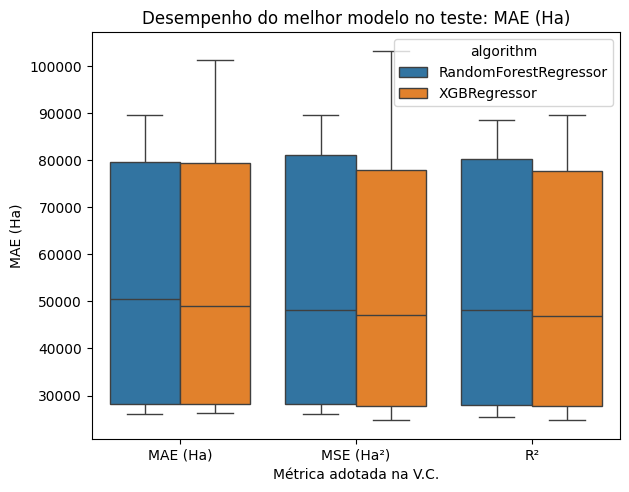

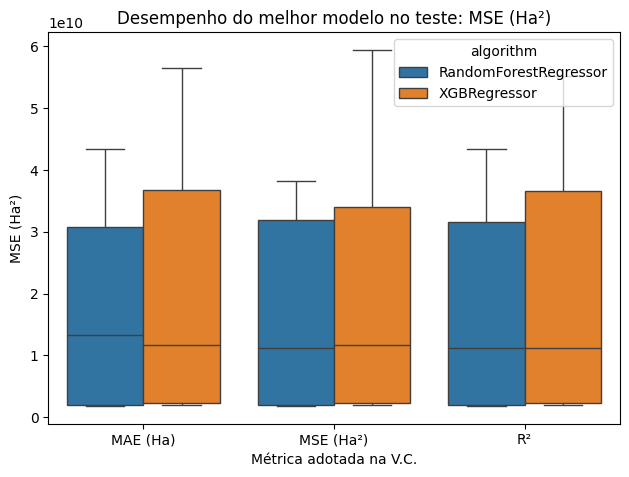

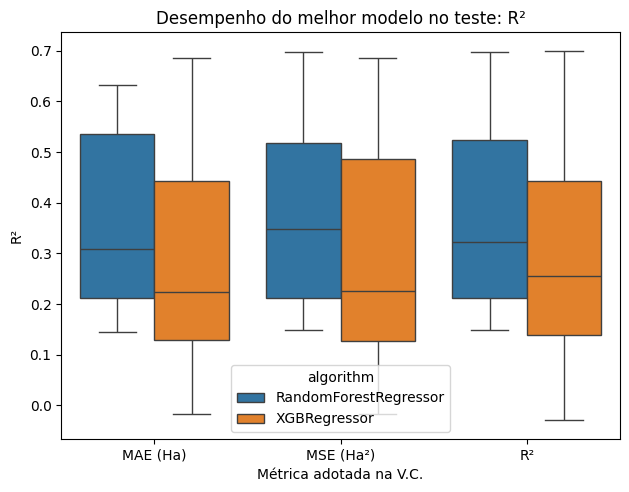

In [131]:
# Formatação (PERF_ remete à performance)
PERF_TITLE = "Desempenho do melhor modelo no teste: {metric}"
PERF_X_AXIS = "Métrica adotada na V.C."
PERF_Y_AXIS = "{metric}"
PERF_MAP_METRICS = {
    "mae": "MAE (Ha)",
    "mse": "MSE (Ha²)",
    "r2": "R²",
}

# Obtém versão normalizada por validação cruzada
df_normalized = normalize_df_exp_plan_cv(df_exp_plan)

# Ajusta formatação das métricas
df_formatted = df_normalized.copy()
df_formatted[_CV_METRIC] = df_formatted[_CV_METRIC].map(PERF_MAP_METRICS)

# Exibe resultados das métricas por melhor cenário das validações cruzadas
for metric, mapped in PERF_MAP_METRICS.items():
    metric_col = f"best_model_test_{metric}"

    sns.boxplot(data=df_formatted, x=_CV_METRIC, y=metric_col, hue=_ALGORITHM)
    plt.tight_layout()
    plt.title(PERF_TITLE.format(metric=mapped))
    plt.xlabel(PERF_X_AXIS)
    plt.ylabel(PERF_Y_AXIS.format(metric=mapped))
    plt.show()

    print("\n") # Respiro visual

In [132]:
# Formatação
PERF_TABLE_TITLE = "### Tabela comparativa de performance ###"

# Armazena resultados a comporem a tabela de desempenho
perf_data = {
    "modelo": [],
    "métrica": [],
    "média": [],
    "desvio padrão": []
}

# Constrói tabela comparativa de métricas
for metric, formatted in PERF_MAP_METRICS.items():
    for model in _MODELS:
        perf_data["métrica"].append(formatted)
        perf_data["modelo"].append(model)

        df_model = df_normalized[df_normalized[_ALGORITHM] == model]

        perf_data["média"].append(df_model[f"best_model_test_{metric}"].mean()) # Computa média
        perf_data["desvio padrão"].append(df_model[f"best_model_test_{metric}"].std()) # Computa desvio padrão
df_perf_cmp_table = pd.DataFrame(data=perf_data)

# Exibe tabela
print(PERF_TABLE_TITLE)
display(df_perf_cmp_table)

### Tabela comparativa de performance ###


,modelo,métrica,média,desvio padrão
0,RandomForestRegressor,MAE (Ha),5.397250e+04,2.639074e+04
1,XGBRegressor,MAE (Ha),5.346785e+04,2.616983e+04
2,RandomForestRegressor,MSE (Ha²),1.659436e+10,1.497225e+10
3,XGBRegressor,MSE (Ha²),1.875545e+10,1.742265e+10
4,RandomForestRegressor,R²,3.719583e-01,1.693104e-01
5,XGBRegressor,R²,2.996112e-01,1.937303e-01


### Análise

## Análise de Coeficientes

Para assegurar a interpretabilidade, serão considerados apenas os casos sem PCA aplicado, isto é, com `PCA=0`.

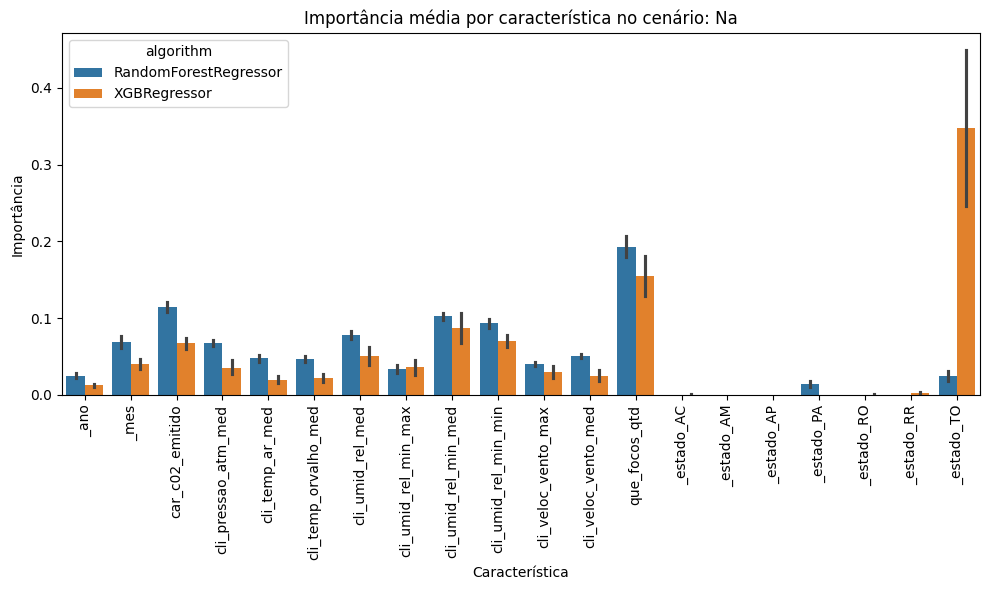

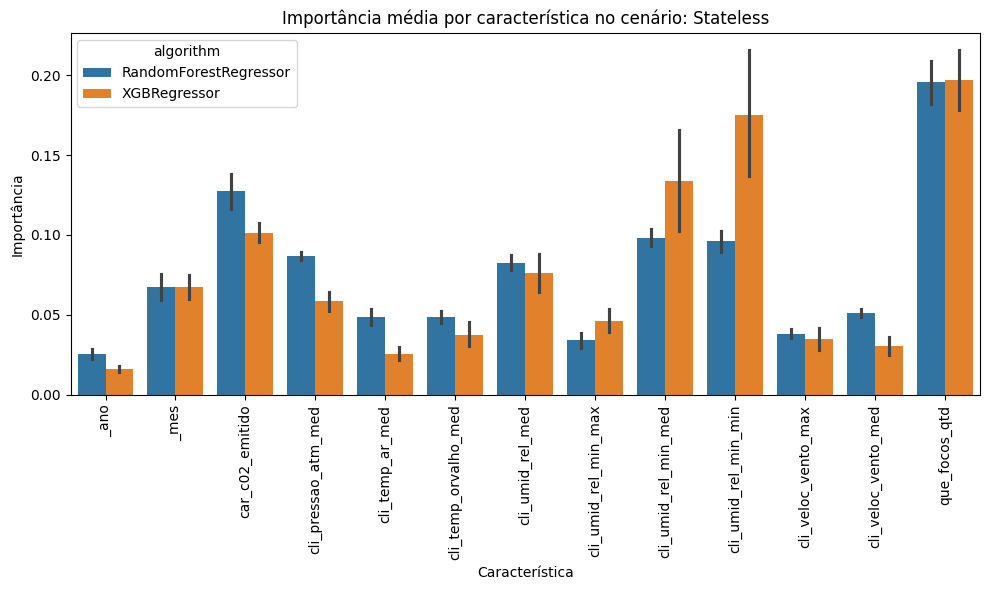

In [133]:
COEF_MASK = "FS={scenario}"

# Formatação
COEF_TITLE = "Importância média por característica no cenário: {scenario}"
COEF_X_AXIS = "Característica"
COEF_Y_AXIS = "Importância"

df_pcaless = df_exp_plan[df_exp_plan[_PCA] == 0]

for scenario in _FS_SCENARIOS:
    df_scenario = df_pcaless[
        df_pcaless[_CASE].apply(
            lambda key: COEF_MASK.format(scenario=scenario) in key
        )
    ]

    df_avg_coefs = get_avg_coefs(df_scenario)

    # Plota gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_avg_coefs,
        x=_FEATURE,
        y=_IMPORTANCE,
        hue=_ALGORITHM
    )
    plt.title(COEF_TITLE.format(scenario=scenario.capitalize()))
    plt.xlabel(COEF_X_AXIS)
    plt.ylabel(COEF_Y_AXIS)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

### Análise

## Análise de Cenários de Pré-Processamento

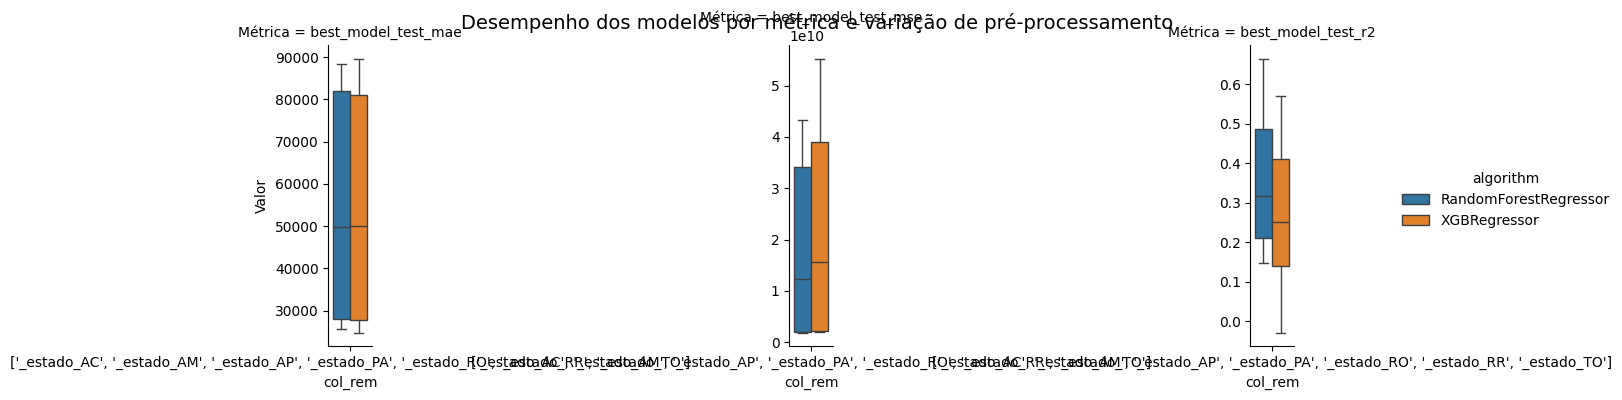

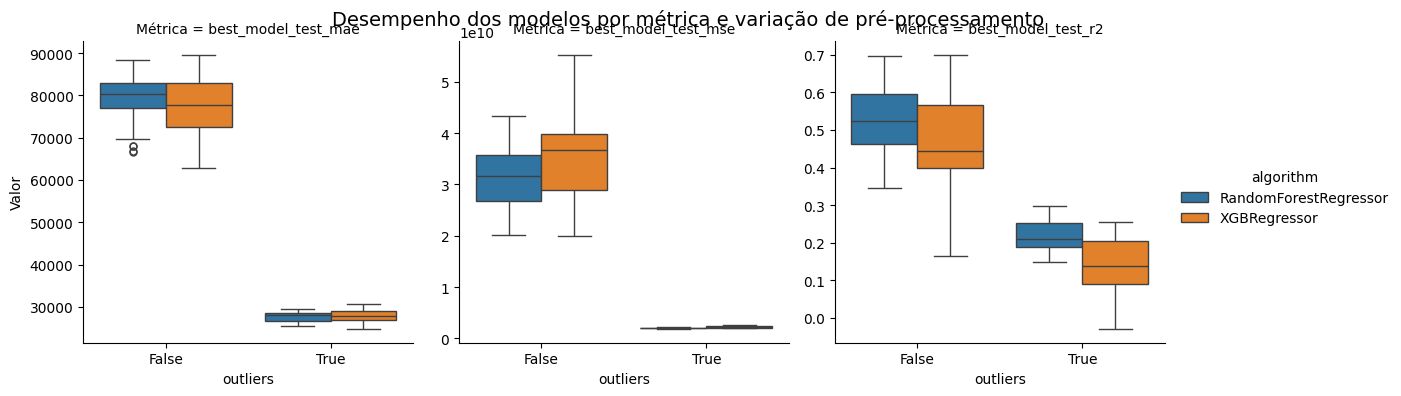

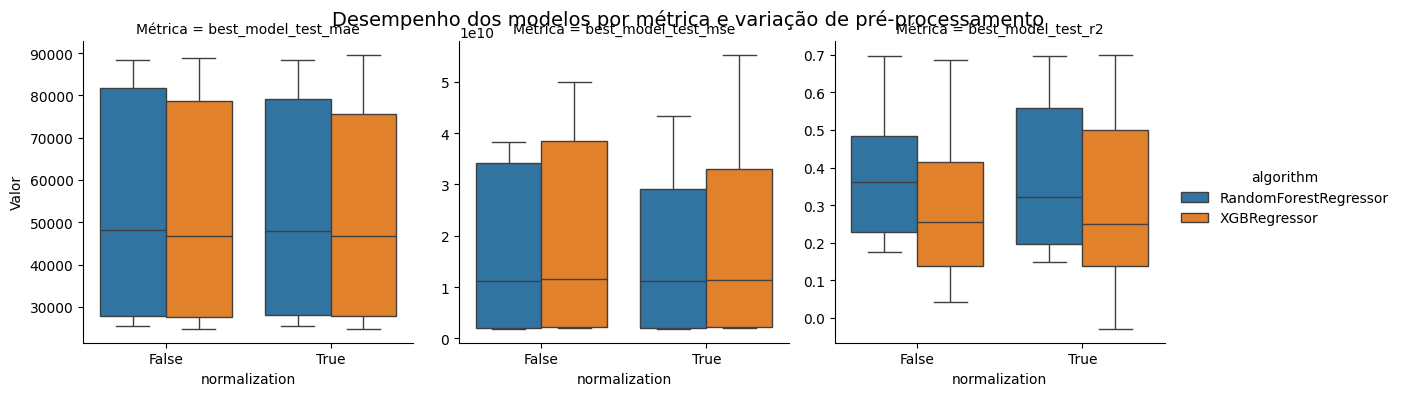

In [160]:
PRE_REF_METRIC = "r2" # Métrica de referência usada na V.C.
PRE_STEPS = [_FS, _OUT, _NORM]
PRE_STEPS_NUM = len(PRE_STEPS)
PRE_X_AXIS = ["Cenário de FS", "Outliers Removidos", "Normalização"]
PRE_TEST = "best_model_test"
PRE_METRIC = "Métrica"
PRE_VALUE = "Valor"

# Formatação
PRE_PLOT = "box"

# Restringe apenas aos casos que tenham usado a métrica de referência em sua V.C.
df_pre_proc = normalize_df_exp_plan_cv(df_exp_plan)
df_pre_proc = df_pre_proc[df_pre_proc[_CV_METRIC] == PRE_REF_METRIC]

for step, x in zip(PRE_STEPS, PRE_X_AXIS):
    # 1. Transforma o dataframe para formato longo
    df = df_pre_proc.melt(
        id_vars=[_ALGORITHM, step],  # colunas que permanecem
        value_vars=[f"{PRE_TEST}_{metric}" for metric in _METRICS],  # métricas
        var_name= PRE_METRIC,
        value_name=PRE_VALUE
    )

    # Gráfico: um por variação do pré-processamento
    g = sns.catplot(
        data=df,
        kind=PRE_PLOT,
        x=step,
        y=PRE_VALUE,
        hue=_ALGORITHM,
        col=PRE_METRIC,
        col_wrap=3,  # Controla quantos gráficos por linha
        height=4,
        aspect=1,
        sharey=False # Gráficos não compartilham escala
    )

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Desempenho dos modelos por métrica e variação de pré-processamento", fontsize=14)
    plt.show()

    print("\n")